In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics
from src.IDs import *


# Mix high-conf SNPs and two-sided single nuc mismatches

## Get mismatches

In [4]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20241121/")
data_df = pd.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", sep="\s+")

In [5]:
def do_it_all(focal_sample_id, denovo_chrom, flow_cell_type=None):
    filtered_high_conf_mismatches_df = pl.scan_parquet(
        [str(output_path / f"read_analysis/{R.sample_set}/{R.sample_id}/{R.flow_cell}/{denovo_chrom}/high_confidence_snps.parquet") \
            for R in data_df.itertuples()
            if (flow_cell_type is None) or (R.flow_cell_type == flow_cell_type) and R.sample_id == focal_sample_id]
    )
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
            )
        )
        return df

    context_df = (filtered_high_conf_mismatches_df
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
    
    #
    # 4. Calculate stats
    # 
    flanking = 3

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("fits1_before") >= flanking) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("fits2_before") >= flanking) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
            ),
        ]
    )
    
    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )
    
    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 1
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("qual_start1") // to_round * to_round).alias("qual_rounded"),
        )
        .group_by(["qual_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["qual_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("qual_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt
    
    

In [6]:
len(data_df["flow_cell"].unique())

58

In [7]:
len(data_df["sample_id"].unique())

9

In [8]:
data_df["flow_cell_type"].value_counts()

flow_cell_type
revio_unbinned    29
sequel_ii         29
revio_40           2
Name: count, dtype: int64

# Calculate stat per technology

In [9]:
CEPH_samples_for_tech = sorted(data_df[data_df["flow_cell_type"] == "revio_unbinned"]["sample_id"].unique())

In [10]:
%%time 
dfs = []
# for chrom in aut_chrom_names[20:21]:
#     print(chrom)
#     dfs.append(do_it_all("200080", chrom, flow_cell_type="revio"))
dfs = joblib.Parallel(n_jobs=2, verbose=50)(
    joblib.delayed(do_it_all)(focal_sample_id, chrom, "revio_unbinned") \
    for chrom in aut_chrom_names[:1]
    for focal_sample_id in CEPH_samples_for_tech[:9]
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  8.0min


/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  9.1min


/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed: 12.4min


/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 14.7min


/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed: 16.9min


/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=2)]: Done   6 out of   8 | elapsed: 18.9min remaining:  6.3min


/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/tmp/ipykernel_1993651/3666066657.py:83: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_1993651/3666066657.py:84: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed: 28.0min finished
CPU times: user 2.76 s, sys: 1.36 s, total: 4.11 s
Wall time: 27min 57s


In [17]:
CEPH_samples_for_tech[:6]

['PD46180c', 'PD50477f', 'PD50489e', 'PD50508b', 'PD50519d', 'PD50521b']

# Plotting 

In [12]:
def plot_per_condition(dfs, ax, condition=None, cumsum=True):
    if condition is None:
        condition = pl.lit(True)
        
    putative_gc_df_hap_cnt = (
        pl.concat([x.filter(condition)[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
        .group_by(["qual_rounded"])
        .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
        .sort("qual_rounded")
    )
        
    import statsmodels.stats.proportion
    if cumsum:
        A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
        B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
    else:
        A = putative_gc_df_hap_cnt["x_vs_y/z"]
        B = putative_gc_df_hap_cnt["x_vs_y/x"]
    
    p = A / B 
    lo, hi = statsmodels.stats.proportion.proportion_confint(
        A, B,
        method="beta", 
        alpha=0.05
    )

    ax.errorbar(
        x = putative_gc_df_hap_cnt["qual_rounded"],
        y = p,
        yerr = [p-lo, hi-p],
        fmt = '.'
    )

    ax.axhline(0.01, ls="--", lw=0.5, c="black")
    ax.axhline(0.1, ls="--", lw=0.5, c="black")

    ax.set_xlabel("BQ (lower threshold)");
    ax.set_ylabel("Estimated false positive rate");
    ax.set_yscale("log")
    #plt.ylim(0.95,1);


    
    

## All

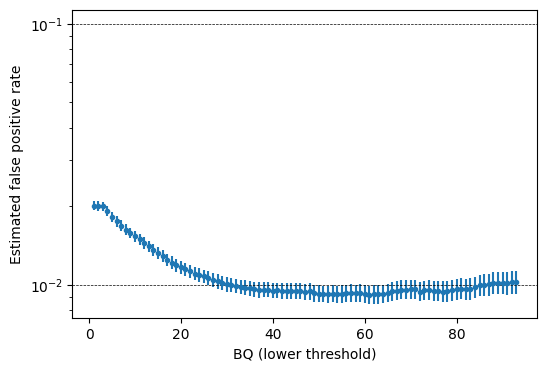

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_per_condition(dfs[:3, ax, condition=None, cumsum=True)

## Per sample

IndexError: list index out of range

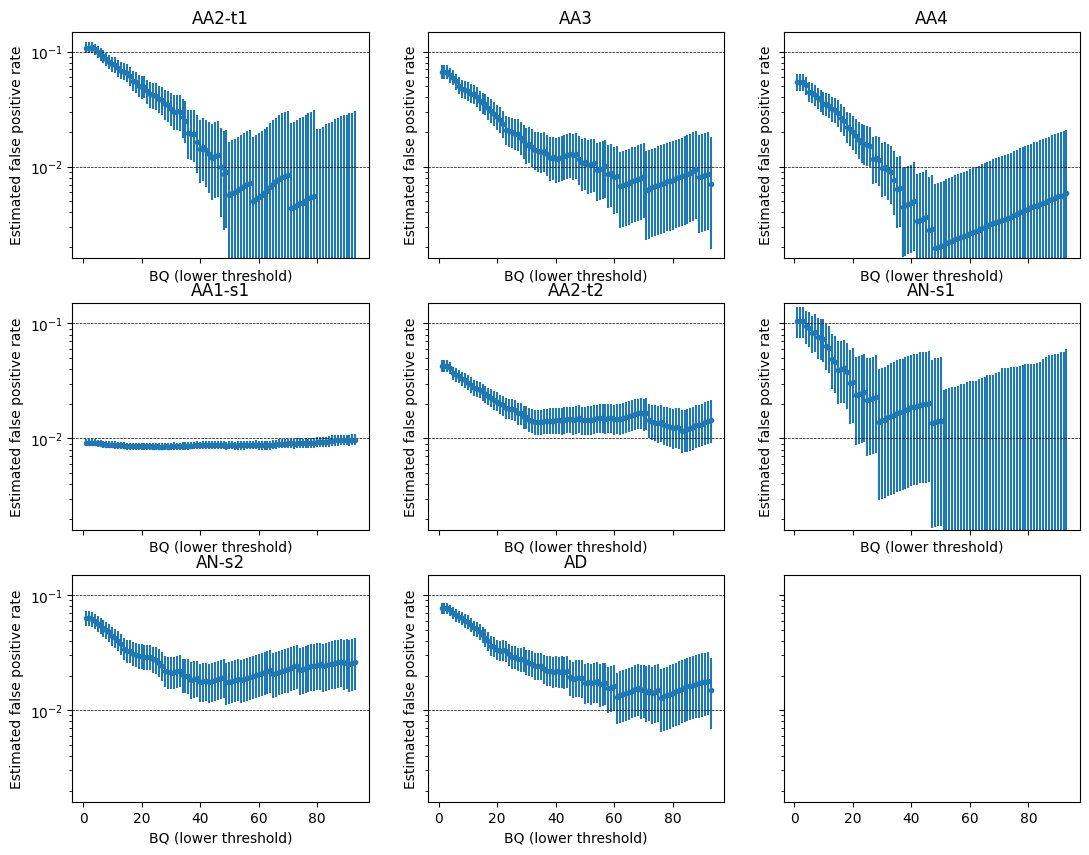

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(13,10), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    plot_per_condition(dfs, ax, condition=(pl.col("focal_sample_id") == CEPH_samples_for_tech[i]), cumsum=True)
    ax.set_title(sample_id_to_paper_label[CEPH_samples_for_tech[i]])

plt.tight_layout()

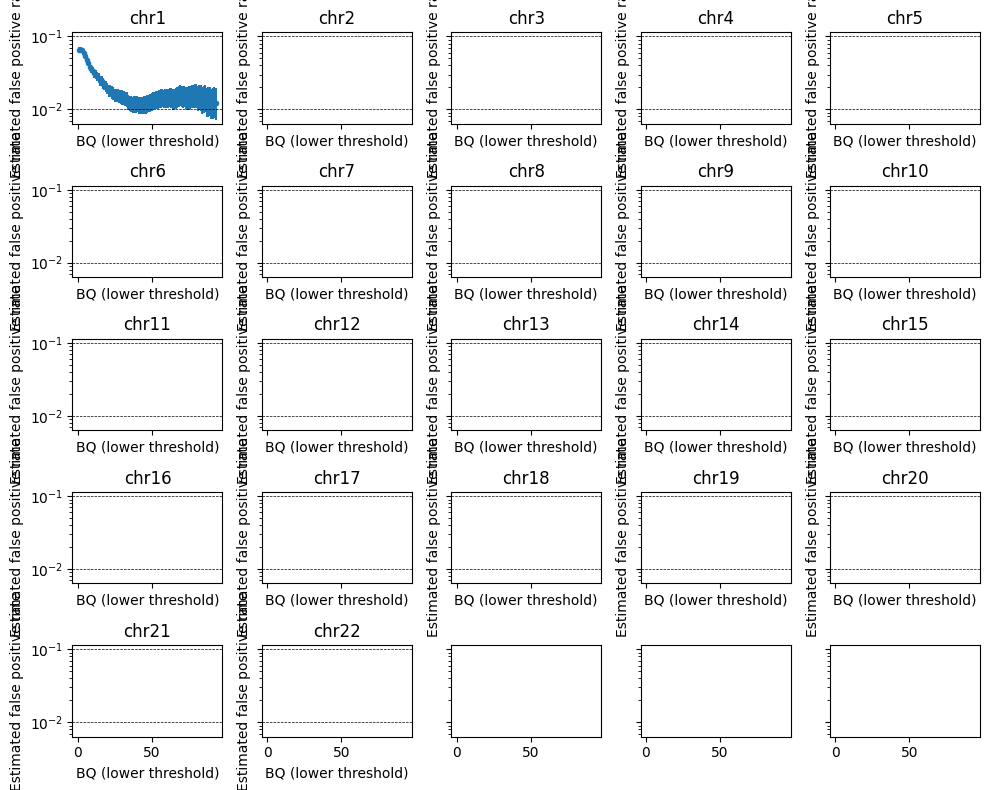

In [21]:
fig, axs = plt.subplots(5, 5, figsize=(10, 8), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()[:len(aut_chrom_names)]):
    plot_per_condition(dfs, ax, condition=(pl.col("chrom") == aut_chrom_names[i]))
    ax.set_title(aut_chrom_names[i])

plt.tight_layout()

# Plot it all

In [22]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
    .group_by(["qual_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
    .sort("qual_rounded")
)



CPU times: user 0 ns, sys: 2.81 ms, total: 2.81 ms
Wall time: 2.86 ms


In [23]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(putative_gc_df_hap_cnt)

qual_rounded,x_vs_y/y,x_vs_y/z,x_vs_y/x
u8,u32,u32,u32
1,25,0,1
2,6060,12,40
3,43635,66,379
4,45914,76,411
5,32396,59,272
6,24933,42,246
7,20141,42,177
8,16843,24,160
9,14332,19,129


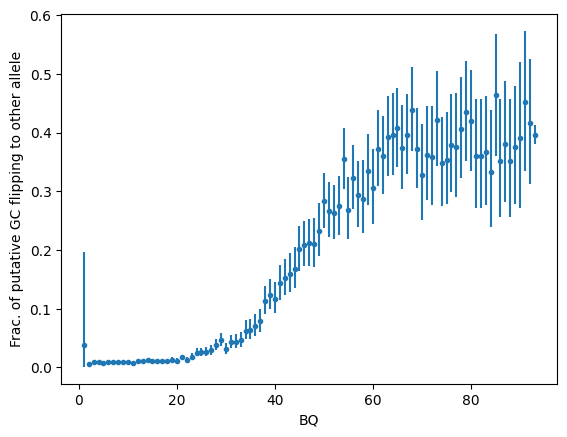

In [24]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] + putative_gc_df_hap_cnt["x_vs_y/y"]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


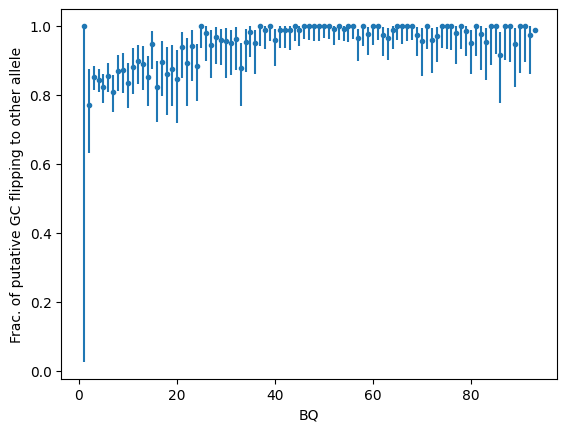

In [25]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] 
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


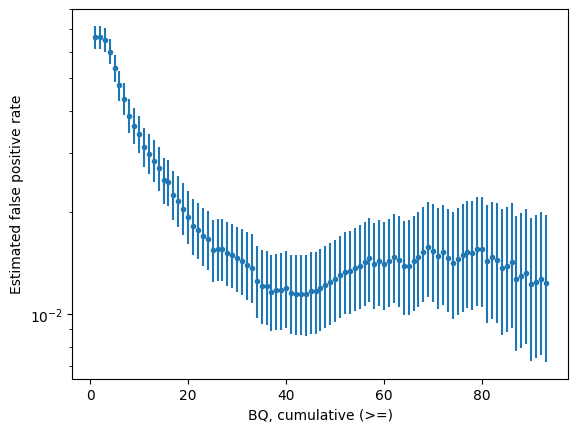

In [26]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ, cumulative (>=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
#plt.ylim(0.95,1);


# BQ as distance from start/end of read

## Read length

In [71]:
def get_read_lengths(focal_sample_id, denovo_chrom, flow_cell_type=None):
    filtered_high_conf_mismatches_df = pl.scan_parquet(
        [str(output_path / f"read_analysis/{R.sample_set}/{R.sample_id}/{R.flow_cell}/{denovo_chrom}/high_confidence_snps.parquet") \
            for R in data_df.itertuples()
            if (flow_cell_type is None) or (R.flow_cell_type == flow_cell_type) and R.sample_id == focal_sample_id]
    )
    read_lengths = filtered_high_conf_mismatches_df.unique(["read_name"]).select("read_length1")

    read_lengths = read_lengths.collect(streaming=True)
    
    return read_lengths


Mean: 20372.519845221093
Median: 19543.0
SE: 3900.2282546519914
Quantiles 1%, 5%, 95%, 99%: [14264. 15630. 27948. 32111.]
CPU times: user 1min 8s, sys: 5.36 s, total: 1min 14s
Wall time: 30.9 s


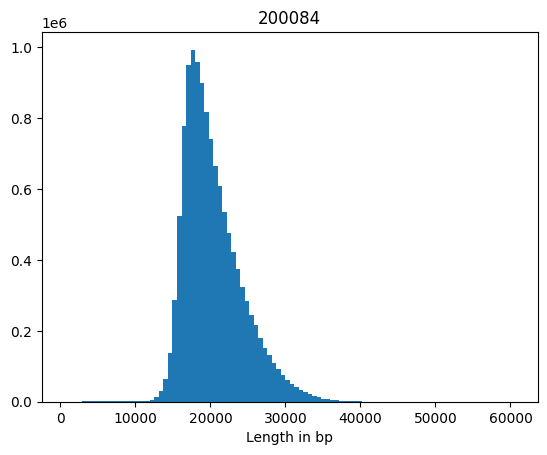

In [74]:
%%time
sample_id = CEPH_samples_for_tech[2]
read_lengths = pl.concat([get_read_lengths(sample_id, "chr1", "revio_40") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

## Errors at read ends

In [99]:
def do_it_all_start(focal_sample_id, denovo_chrom, flow_cell_type=None, min_mapq = 93):
    filtered_high_conf_mismatches_df = pl.scan_parquet(
        [str(output_path / f"read_analysis/{R.sample_set}/{R.sample_id}/{R.flow_cell}/{denovo_chrom}/high_confidence_snps.parquet") \
            for R in data_df.itertuples()
            if (flow_cell_type is None) or (R.flow_cell_type == flow_cell_type) and R.sample_id == focal_sample_id]
    )
        
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
        read_trimming = 0, # Don't trim ends just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)    
    
#    display(filtered_high_conf_mismatches_df)
        
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
                pl.col("start").cum_count().alias("snp_index"),
                pl.col("start").cum_count(reverse=True).alias("snp_rev_index"),
            )
        )
        return df

    context_df = (filtered_high_conf_mismatches_df
        .filter((pl.col("qual_start1") >= min_mapq) & (pl.col("qual_start2") >= min_mapq))
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
        
    #
    # 4. Calculate stats
    # 
    flanking = 3       # including itself, if it fits
    
    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_index") == 1) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_rev_index") == 1) & (pl.col("fits1_before") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length1") - pl.col("end")).alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_index") == 1) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_rev_index") == 1) & (pl.col("fits2_before") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length2") - pl.col("end")).alias("dist_from_end"))
            ),
        ]
    )
    
    # print(putative_gc_df_hap)
    # return

    

    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )

    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 50
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("dist_from_end") // to_round * to_round).alias("dist_from_end_rounded"),
        )
        .group_by(["dist_from_end_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["dist_from_end_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("dist_from_end_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt

In [106]:
%%time 
startdfs = joblib.Parallel(n_jobs=4, verbose=50)(
    joblib.delayed(do_it_all_start)(focal_sampld_id, chrom, "revio_50", min_mapq=50) 
        for chrom in aut_chrom_names[:1]
        for focal_sampld_id in CEPH_samples_for_tech[:6]
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


/tmp/ipykernel_3331393/3401669949.py:106: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3331393/3401669949.py:107: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.9min


/tmp/ipykernel_3331393/3401669949.py:106: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3331393/3401669949.py:107: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   2 out of   6 | elapsed:  3.3min remaining:  6.6min


/tmp/ipykernel_3331393/3401669949.py:106: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3331393/3401669949.py:107: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:  5.4min remaining:  5.4min


/tmp/ipykernel_3331393/3401669949.py:106: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3331393/3401669949.py:107: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   4 out of   6 | elapsed:  6.0min remaining:  3.0min


/tmp/ipykernel_3331393/3401669949.py:106: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3331393/3401669949.py:107: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/tmp/ipykernel_3331393/3401669949.py:106: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_3331393/3401669949.py:107: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  7.0min finished
CPU times: user 1.09 s, sys: 1.19 s, total: 2.28 s
Wall time: 6min 58s


In [107]:
for i in range(len(startdfs)):
    if "x_vs_y/z" not in startdfs[i].columns:
        startdfs[i] = startdfs[i].with_columns(pl.lit(0).alias("x_vs_y/z"))

In [108]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["dist_from_end_rounded", "x_vs_y/y", "x_vs_y/x", "x_vs_y/z"]] for x in startdfs], how="vertical_relaxed")
    .group_by(["dist_from_end_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/x").sum(), pl.col("x_vs_y/z").sum())
    .sort("dist_from_end_rounded")
)



CPU times: user 3.21 ms, sys: 0 ns, total: 3.21 ms
Wall time: 1.91 ms


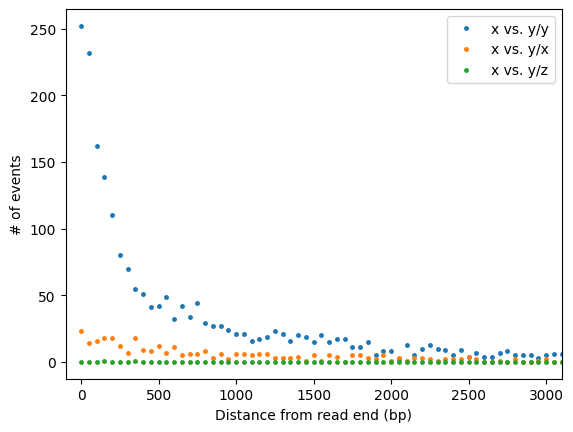

In [109]:
import statsmodels.stats.proportion

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/y"],
    '.',
    ms=5,
    label="x vs. y/y",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    '.',
    ms=5,
    label="x vs. y/x",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/z"],
    '.',
    ms=5,
    label="x vs. y/z",
)


plt.xlabel("Distance from read end (bp)");
plt.ylabel("# of events");
#plt.yscale("log")
plt.xlim(-100, 3100);
plt.legend();


/tmp/ipykernel_3331393/3959013300.py:8: RuntimeWarning: invalid value encountered in divide
  data /= data.sum(axis=1)[:,np.newaxis]


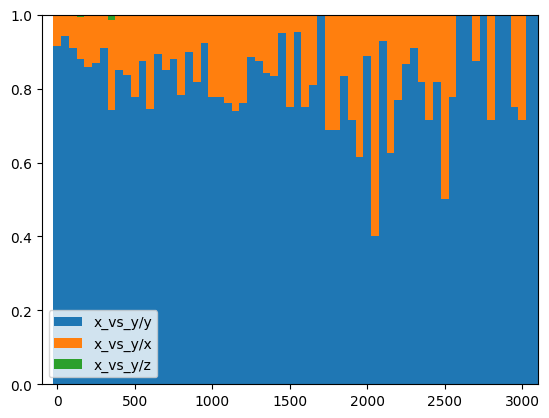

In [110]:
# Sample data (replace this with your matrix)
data = np.array([
    putative_gc_df_hap_cnt["x_vs_y/y"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    putative_gc_df_hap_cnt["x_vs_y/z"]
]).T.astype(float)

data /= data.sum(axis=1)[:,np.newaxis]

# Number of rows and columns in the matrix
num_rows, num_cols = data.shape

# # Initialize a color map for better visualization
# colors = plt.cm.viridis(np.linspace(0, 1, num_cols))

# Plotting the stacked bars
fig, ax = plt.subplots()

for i in range(num_cols):
    bottom = np.sum(data[:,:i], axis=1)
    ax.bar(putative_gc_df_hap_cnt["dist_from_end_rounded"].to_numpy(), data[:,i], bottom=bottom, width=50)
    

# Adding labels and legend
ax.legend(["x_vs_y/y", "x_vs_y/x", "x_vs_y/z"])
ax.set_xlim(-100,3100);

# Show the plot
plt.show()


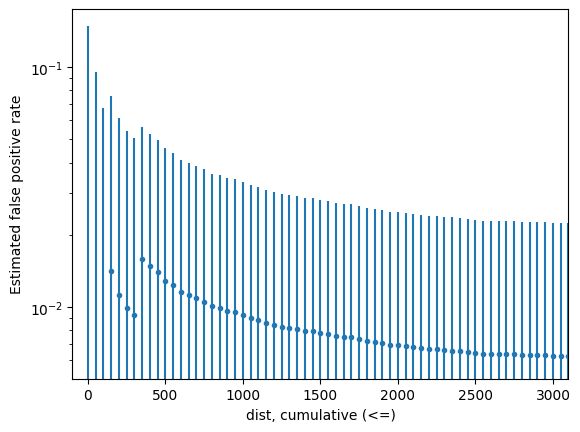

In [111]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"])
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"])
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["dist_from_end_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("dist, cumulative (<=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
plt.xlim(-100, 3100);
